# Figsetup
Using 20200408 Chou's data, unit1.<br>
shortcaption: Temporal kernel of a iP-RGC <br>
label: TK_LED

In [1]:
filename = 'TK_LED'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [4]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [5]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

In [6]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

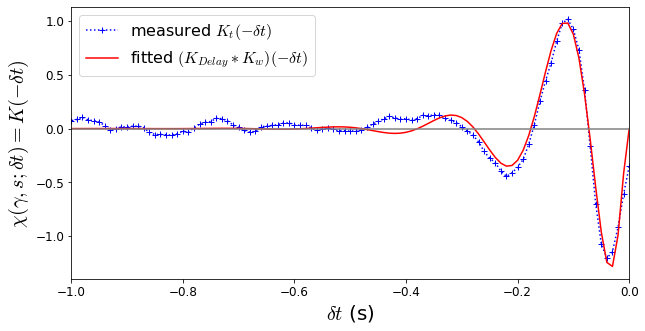

In [9]:
plt.rcParams["font.size"] = 12

dt = 0.01
x_list, T_list, rstate_list = expSnR(['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_cSTA_sort_unit1'], dt, 'LED', np.arange(60)+1)
x = x_list[0]
x = x-np.mean(x)/np.std(x)
# cSTA_list = [0]*60
# dcn = []
# fig, ax = plt.subplots(nrows=8, ncols=8, constrained_layout=True, sharex=True, sharey=True)

cn = 53

rstate = rstate_list[0][cn,:]

cSTA = np.correlate(x, rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt

plt.plot(taxis, cSTA, 'b+:')



name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)
#-------------------------------------
para_dict['error'] = np.zeros(60)

epsilon = 10. #1/sec
gamma = 25.
omegastar = 30. 
deltastar = 0.
tau_y = 0.04
Dmp = 10.

popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis), cSTA, 
                      p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                      bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                [np.inf , np.inf, np.inf   ,  np.pi/2 , 0.1  , np.inf ] ))

for l in range(len(popt)):
    para_dict[name_list[l]][cn] = popt[l]
#     print(popt)
fit_cSTA = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
# para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
plt.plot(taxis, fit_cSTA, 'r-')
plt.xlabel(r'$\delta t$ (s)', fontsize = 20)
plt.ylabel('$\chi(\gamma, s; \delta t) = K(-\delta t)$ ', fontsize = 20)

plt.axhline(0, c='gray')
plt.legend( (r'measured $K_t(-\delta t)$', r'fitted $(K_{Delay}*K_w)(-\delta t)$'), fontsize = 16 )
plt.xlim([-1.0,0])
fig = plt.gcf()
plt.xlim([-1.0,0])
fig.set_size_inches(10, 5)


In [10]:

fig.savefig('D:\\GoogleDrive\\retina\\thesis\\fig\\R\\'+filename+'.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)